In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as scs
import scipy.optimize as sco
import matplotlib.pyplot as plt
import datetime
import pandas_datareader.data as pdr
import yfinance as yf
yf.pdr_override()
from pandas import Series, DataFrame

### 資料處理

In [2]:
bet_etf_set = ['IVE','VTI','VEA','VWO', 'IWS', 'IWN', 'SHV', 'VTIP', 'IUSB', 'LQD', 'BNDX', 'VWOB', 'MUB']
wise_etf_set = ['VTI', 'SCHB', 'SPY', 'VEA', 'SCHF', 'EFA', 'VWO', 'IEMG', 'EEM', 'VGIT', 'VGSH', 'LQD', 'VCIT', 'VCSH', 'SJNK', 'HYS', 'SHYG', 'TIP', 'VNQ', 'IYR', 'ICF']
sch_etf_set = ['SCHX', 'FNDX', 'SCHA', 'FNDA', 'SCHF', 'FNDF', 'SCHC', 'FNDC', 'SCHE', 'FNDE', 'SCHR', 'VMBS', 'SCHP', 'BNDX', 'SHYG', 'EMLC', 'SCHH', 'VNQI', 'IAU']

def process_data(data_set):
    start = datetime.datetime(2015, 4, 1)
    end = datetime.date.today()
    num_assets = len(data_set)
    
    all_data = {}
    for ticker in data_set:
        all_data[ticker] = pdr.get_data_yahoo(ticker, start, end)
        
    return DataFrame({tic: data['Adj Close'] for tic, data in all_data.items()})

In [3]:
betterment = process_data(bet_etf_set)
wisebanyan = process_data(wise_etf_set)
schwab = process_data(sch_etf_set)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### 計算日報酬、風險

In [4]:
def returns(firm_dtf):
    return np.log(firm_dtf / firm_dtf.shift(1)) # daily return in percentage

def cov_matrix(ret_dtf):
    return ret_dtf.cov() * 252 # 252 trading days
    

In [5]:
bet_ret = returns(betterment)
wise_ret = returns(wisebanyan)
sch_ret = returns(schwab)

bet_cov = cov_matrix(bet_ret)
wise_cov = cov_matrix(wise_ret)
sch_cov = cov_matrix(sch_ret)

### 隨機分配權重

In [6]:
def weights(firm_dtf):
    w = np.random.random(len(firm_dtf.columns))
    w/= np.sum(w)
    return w

In [7]:
bet_weights = weights(betterment)
wise_weights = weights(wisebanyan)
sch_weights = weights(schwab)

### 計算組合年化報酬、變異數、標準差

In [8]:
def port_data(ret, cov, weights):
    port_ret = np.sum(ret.mean()* weights) * 252
    port_var = np.dot(weights.T, np.dot(cov * 252, weights))
    port_std = np.sqrt(port_var)
    #port_sharpe = port_ret / port_var
    
    return port_ret, port_var, port_std

In [9]:
bet_port = port_data(bet_ret, bet_cov, bet_weights)
wise_port = port_data(wise_ret, wise_cov, wise_weights)
sch_port = port_data(sch_ret, sch_cov, sch_weights)

In [10]:
print('betterment:', bet_port)
print('wisebanyan:', wise_port)
print('schwab:', sch_port)

betterment: (0.026060129260560713, 1.9210940963037064, 1.3860353878251834)
wisebanyan: (0.02347114800209866, 4.083936789000643, 2.0208752532011083)
schwab: (0.01905081256837856, 2.5941462147600465, 1.6106353450610869)


### 求最小變異數組合

In [11]:
def statistics_bet(weights):
    weights = np.array(weights)
    port_ret = np.sum(bet_ret.mean()*weights) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(bet_ret.cov()*252,weights)))
    
    return np.array([port_ret, port_vol, port_ret/port_vol])

def statistics_wise(weights):
    weights = np.array(weights)
    port_ret = np.sum(wise_ret.mean()*weights) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(wise_ret.cov()*252,weights)))
    
    return np.array([port_ret, port_vol, port_ret/port_vol])

def statistics_sch(weights):
    weights = np.array(weights)
    port_ret = np.sum(sch_ret.mean()*weights) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(sch_ret.cov()*252,weights)))
    
    return np.array([port_ret, port_vol, port_ret/port_vol])

def num_assets(firm_dtf):
    return len(firm_dtf.columns)

def bnds(num_assets):
    return tuple((0,1) for x in range(num_assets))

In [12]:
noa_bet = num_assets(betterment)
noa_wise = num_assets(wisebanyan)
noa_sch = num_assets(schwab)
bnds_bet = bnds(noa_bet)
bnds_wise = bnds(noa_wise)
bnds_sch = bnds(noa_sch)

In [13]:
def min_var_bet(weights):
    return statistics_bet(weights)[1]

def min_var_wise(weights):
    return statistics_wise(weights)[1]

def min_var_sch(weights):
    return statistics_sch(weights)[1]


cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bet_opt_vol = sco.minimize(min_var_bet, noa_bet* [1./noa_bet,], method= 'SLSQP', bounds = bnds_bet, constraints = cons)
wise_opt_vol = sco.minimize(min_var_wise, noa_wise* [1./noa_wise,], method= 'SLSQP', bounds = bnds_wise, constraints = cons)
sch_opt_vol = sco.minimize(min_var_sch, noa_sch* [1./noa_sch,], method= 'SLSQP', bounds = bnds_sch, constraints = cons)

In [16]:
bet_opt_vol

     fun: 0.00244751331169687
     jac: array([0.00308082, 0.00424752, 0.00361573, 0.00627148, 0.00860504,
       0.00412704, 0.00244199, 0.00305581, 0.00579384, 0.00971965,
       0.00290217, 0.00511085, 0.00422551])
 message: 'Optimization terminated successfully.'
    nfev: 197
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([8.46300746e-05, 1.15874107e-18, 0.00000000e+00, 3.00040507e-19,
       0.00000000e+00, 2.79309273e-03, 9.97122277e-01, 0.00000000e+00,
       0.00000000e+00, 7.21672071e-18, 2.35125921e-18, 3.26277091e-18,
       0.00000000e+00])

In [17]:
statistics_bet(bet_opt_vol.x)

array([1.16559288e-02, 2.44751331e-03, 4.76235562e+00])

In [38]:
statistics_wise(wise_opt_vol.x)

array([0.01921031, 0.00996715, 1.92736142])

In [39]:
statistics_sch(sch_opt_vol.x)

array([0.03124919, 0.02603369, 1.2003365 ])

### 繪製效率前緣（給定多組目標報酬，最小化風險）

In [31]:
target_returns_bet = np.linspace(0.0, 0.07, 50)

target_vol_bet = []
target_vol_wise = []
target_vol_sch = []

cnt = 0
for tar in target_returns_bet:
    cons_bet = ({'type':'eq','fun':lambda x:statistics_bet(x)[0]-tar},{'type':'eq','fun':lambda x:np.sum(x)-1})
    res_bet = sco.minimize(min_var_bet, noa_bet*[1./noa_bet,],method = 'SLSQP', bounds = bnds_bet, constraints = cons_bet)
    target_vol_bet.append(res_bet['fun'])
    cnt += 1
    print(cnt)
target_vol_bet = np.array(target_vol_bet)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [33]:
target_returns_wise = np.linspace(0.0, 0.07, 50)

cnt = 0
for tar in target_returns_wise:
    cons_wise = ({'type':'eq','fun':lambda x:statistics_wise(x)[0]-tar},{'type':'eq','fun':lambda x:np.sum(x)-1})
    res_wise = sco.minimize(min_var_wise, noa_wise*[1./noa_wise,],method = 'SLSQP', bounds = bnds_wise, constraints = cons_wise)
    target_vol_wise.append(res_wise['fun'])
    cnt += 1
    print(cnt)
target_vol_wise = np.array(target_vol_wise)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [35]:
target_returns_sch = np.linspace(0.0, 0.07, 50)

cnt = 0
for tar in target_returns_sch:
    cons_sch = ({'type':'eq','fun':lambda x:statistics_sch(x)[0]-tar},{'type':'eq','fun':lambda x:np.sum(x)-1})
    res_sch = sco.minimize(min_var_sch, noa_sch*[1./noa_sch,],method = 'SLSQP', bounds = bnds_sch, constraints = cons_sch)
    target_vol_sch.append(res_sch['fun'])
    cnt += 1
    print(cnt)
target_vol_sch = np.array(target_vol_sch)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


Betterment Min Vol Portfolio: 0.01165592877719659 0.00244751331169687
WiseBanyan Min Vol Portfolio: 0.019210309690574277 0.009967154820068264
Charles Min Vol Portfolio: 0.031249187818821397 0.026033689605285036


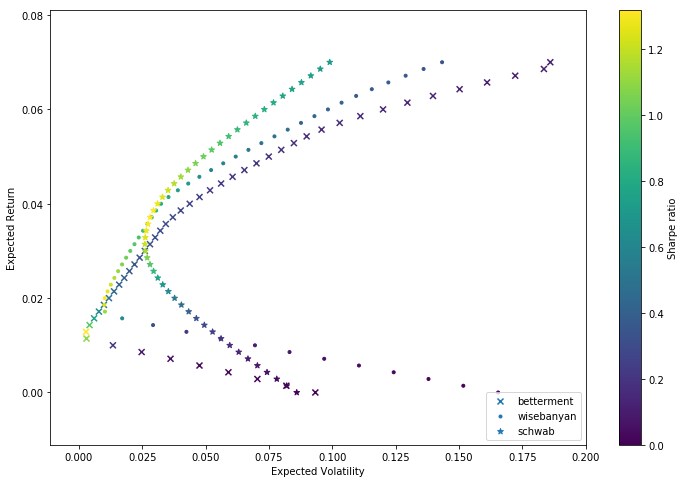

In [37]:
plt.figure(figsize=(12, 8))
plt.scatter(target_vol_bet,target_returns_bet, c = target_returns_bet/target_vol_bet, marker = 'x', label = 'betterment')
plt.scatter(target_vol_wise,target_returns_wise, c = target_returns_wise/target_vol_wise, marker = '.', label = 'wisebanyan')
plt.scatter(target_vol_sch,target_returns_sch, c = target_returns_sch/target_vol_sch, marker = '*', label = 'schwab')


#plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label = 'Sharpe ratio')
plt.legend(loc = 'lower right')

print('Betterment Min Vol Portfolio:', np.sum(bet_ret.mean()* bet_opt_vol.x) * 252, bet_opt_vol.fun)
print('WiseBanyan Min Vol Portfolio:', np.sum(wise_ret.mean()* wise_opt_vol.x) * 252, wise_opt_vol.fun)
print('Charles Min Vol Portfolio:', np.sum(sch_ret.mean()* sch_opt_vol.x) * 252, sch_opt_vol.fun)

